# 2-D Ising Model

We will investigate the 2-d Ising model with Monte Carlo methods. Since there are many internal iterations, it is much faster to run in `C++` with `swig`. 

### Compile with swig

In [1]:
! swig -c++ -python swig/ising.i
! python swig/setup_ising.py build_ext --inplace

### Import from swig

In [2]:
import sys
import os
sys.path.append( os.path.abspath("swig") )
import ising
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### Initialize the system

In [3]:
L = 10
J = 1.0
N = 100
T = 1.
H = 0.
MCSteps = 2000


### Run the simulations for various temperatures


Also plot the average magnetization as a function of the MC step. 

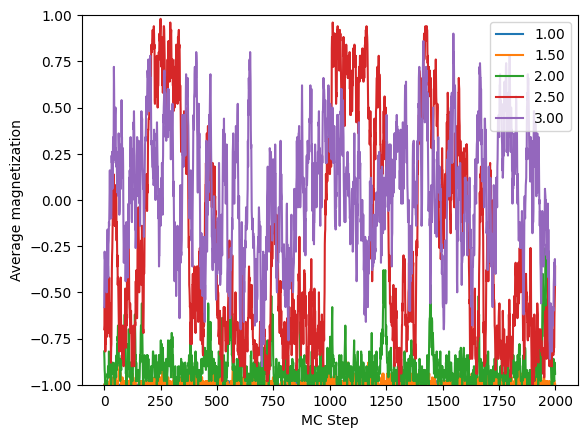

In [ ]:
eAvgVals = []
mAvgVals = []
Tvals = np.linspace(1,3,5)
for T in Tvals:
    i = ising.Ising(J, L, N, T, H)
    i.run(MCSteps)
    mvals = i.get_mvals()
    plt.plot(mvals, label="%3.2f" % (T))
    eAvgVals.append( i.get_eAvg() )
    mAvgVals.append( i.get_mAvg() )

plt.legend()
plt.ylim(-1,1)
plt.xlabel("MC Step")
plt.ylabel("Average magnetization")
plt.show()

### Plot average magnetization versus temperature

Text(0, 0.5, 'Average Magnetization')

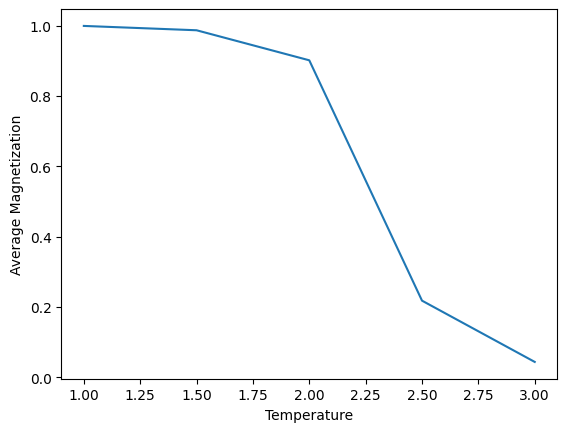

In [5]:
plt.plot(Tvals, np.abs(mAvgVals))
plt.xlabel("Temperature")
plt.ylabel("Average Magnetization")

# Part (A)


generate data for various L and N values and plot them.

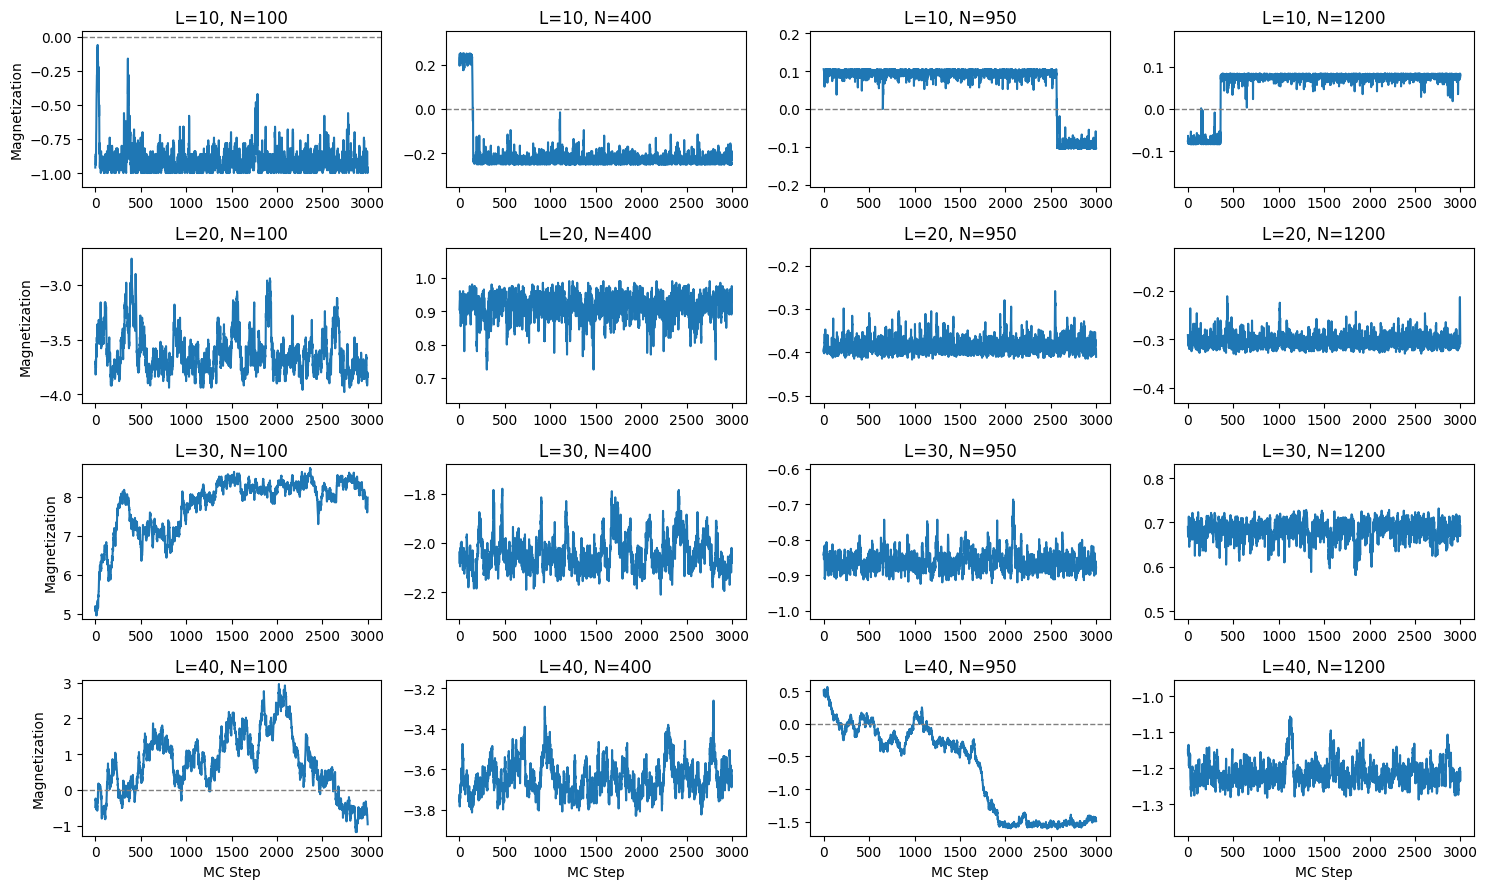

In [66]:
T=2 

L_vals = [10, 20, 30 ,40]              
N_vals = [100, 400, 950, 1200]       

MCSteps = 3000

magnetization_data = {}

fig, axs = plt.subplots(len(L_vals), len(N_vals), figsize=(15, 9), sharey=False)

for iL, L in enumerate(L_vals):
    magnetization_data[L] = {}
    for iN, N in enumerate(N_vals):
        model = ising.Ising(J, L, N, T, H)
        model.run(MCSteps)
        mvals = model.get_mvals()

        # Store magnetization data
        magnetization_data[L][N] = mvals

        # Plot
        ax = axs[iL, iN]
        ax.plot(mvals)
        ax.set_title(f"L={L}, N={N}")
        ax.set_ylim(min(mvals) - 0.1, max(mvals) + 0.1)
        ax.axhline(0, color='gray', linestyle='--', linewidth=1)


        if iL == len(L_vals) - 1:
            ax.set_xlabel("MC Step")
        if iN == 0:
            ax.set_ylabel("Magnetization")

plt.tight_layout()
plt.show()

# Part (B)

In [63]:
#if found the set of values for which L and N, scale as L~N^2, allow for a better fit

L=30
N=950


eAvgVals = []
mAvgVals = []

Tvals_left  = np.linspace(1, 2.21, 250)
Tvals_phase   = np.linspace(2.21, 2.27, 500)
Tvals_right = np.linspace(2.27, 3, 250)

Tvals = np.concatenate([Tvals_left, Tvals_phase[1:], Tvals_right[1:]])

MCSteps = 10000

for T in Tvals:
    i = ising.Ising(J, L, N, T, H)
    i.run(MCSteps)
    mvals = i.get_mvals()
    eAvgVals.append( i.get_eAvg() )
    mAvgVals.append( i.get_mAvg() )

Text(0, 0.5, 'Average Magnetization')

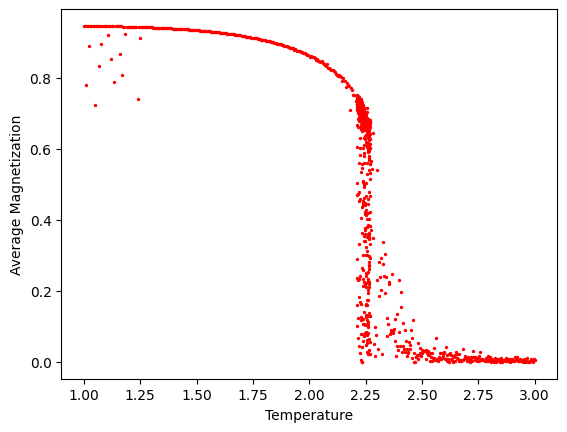

In [64]:

plt.scatter(Tvals, np.abs(mAvgVals),s=2,color='red')
#plt.scatter(Tvals, np.log(np.abs(mAvgVals)),s=2,color='blue')
plt.xlabel("Temperature")
plt.ylabel("Average Magnetization")


#### Fitting Part

In [89]:
from scipy.optimize import curve_fit

def power_law_magnetization(T, Tc, beta):
    T_eff = np.clip(Tc - T, 0, None)  # Clip values above Tc to 0
    return T_eff ** beta



mAvgVals = np.array(mAvgVals)           

m_fit = np.abs(mAvgVals)


initial_guess = [2.24, 0.1]
popt, pcov = curve_fit(power_law_magnetization, Tvals, m_fit, p0=initial_guess)
Tc_fit, beta_fit = popt

print(f"Fitted Tc = {Tc_fit:.4f}, beta = {beta_fit:.4f}")


m_fit_model = power_law_magnetization(T_fit, Tc_fit, beta_fit)

Fitted Tc = 2.2452, beta = 0.1105


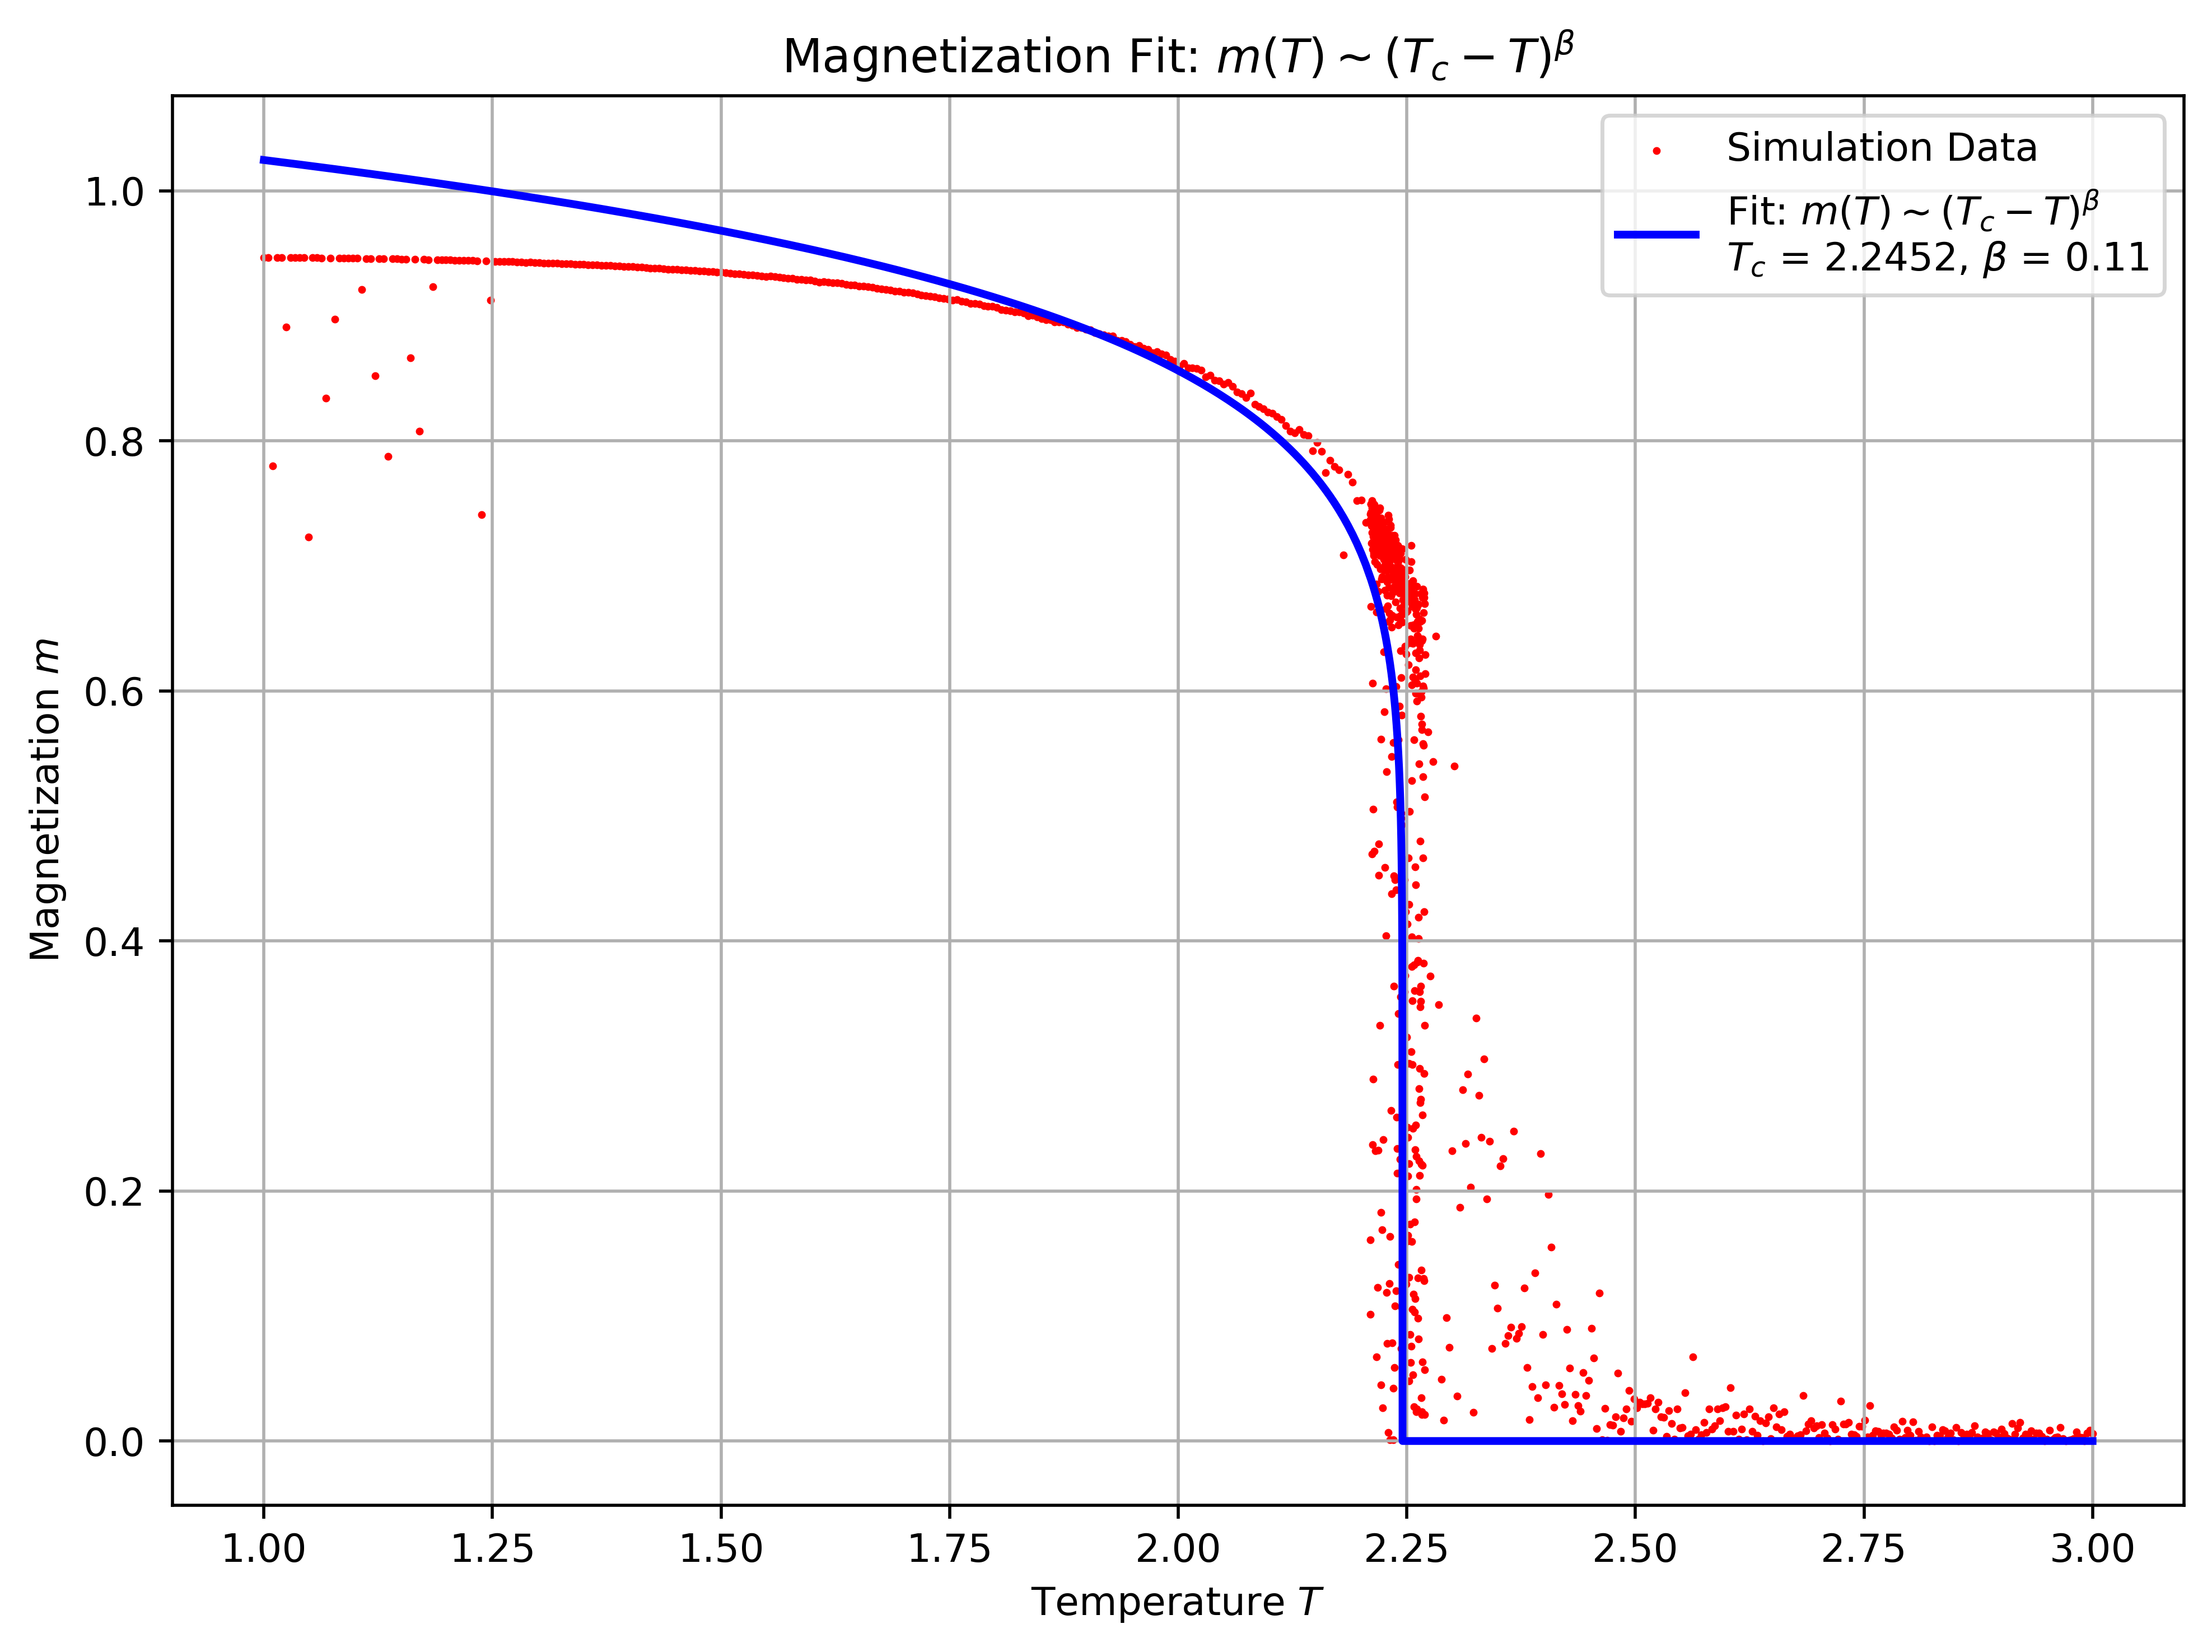

In [90]:
plt.figure(figsize=(8, 6),dpi=500)
plt.scatter(T_fit, m_fit, s=1, color='red', label="Simulation Data")
plt.plot(T_fit, m_fit_model, 'b-', lw=2,
         label=fr"Fit: $m(T) \sim (T_c - T)^{{\beta}}$" + 
               f"\n$T_c$ = {Tc_fit:.4f}, $\\beta$ = {beta_fit:.2f}")
plt.xlabel("Temperature $T$")
plt.ylabel("Magnetization $m$")
plt.title("Magnetization Fit: $m(T) \\sim (T_c - T)^\\beta$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Part (C)

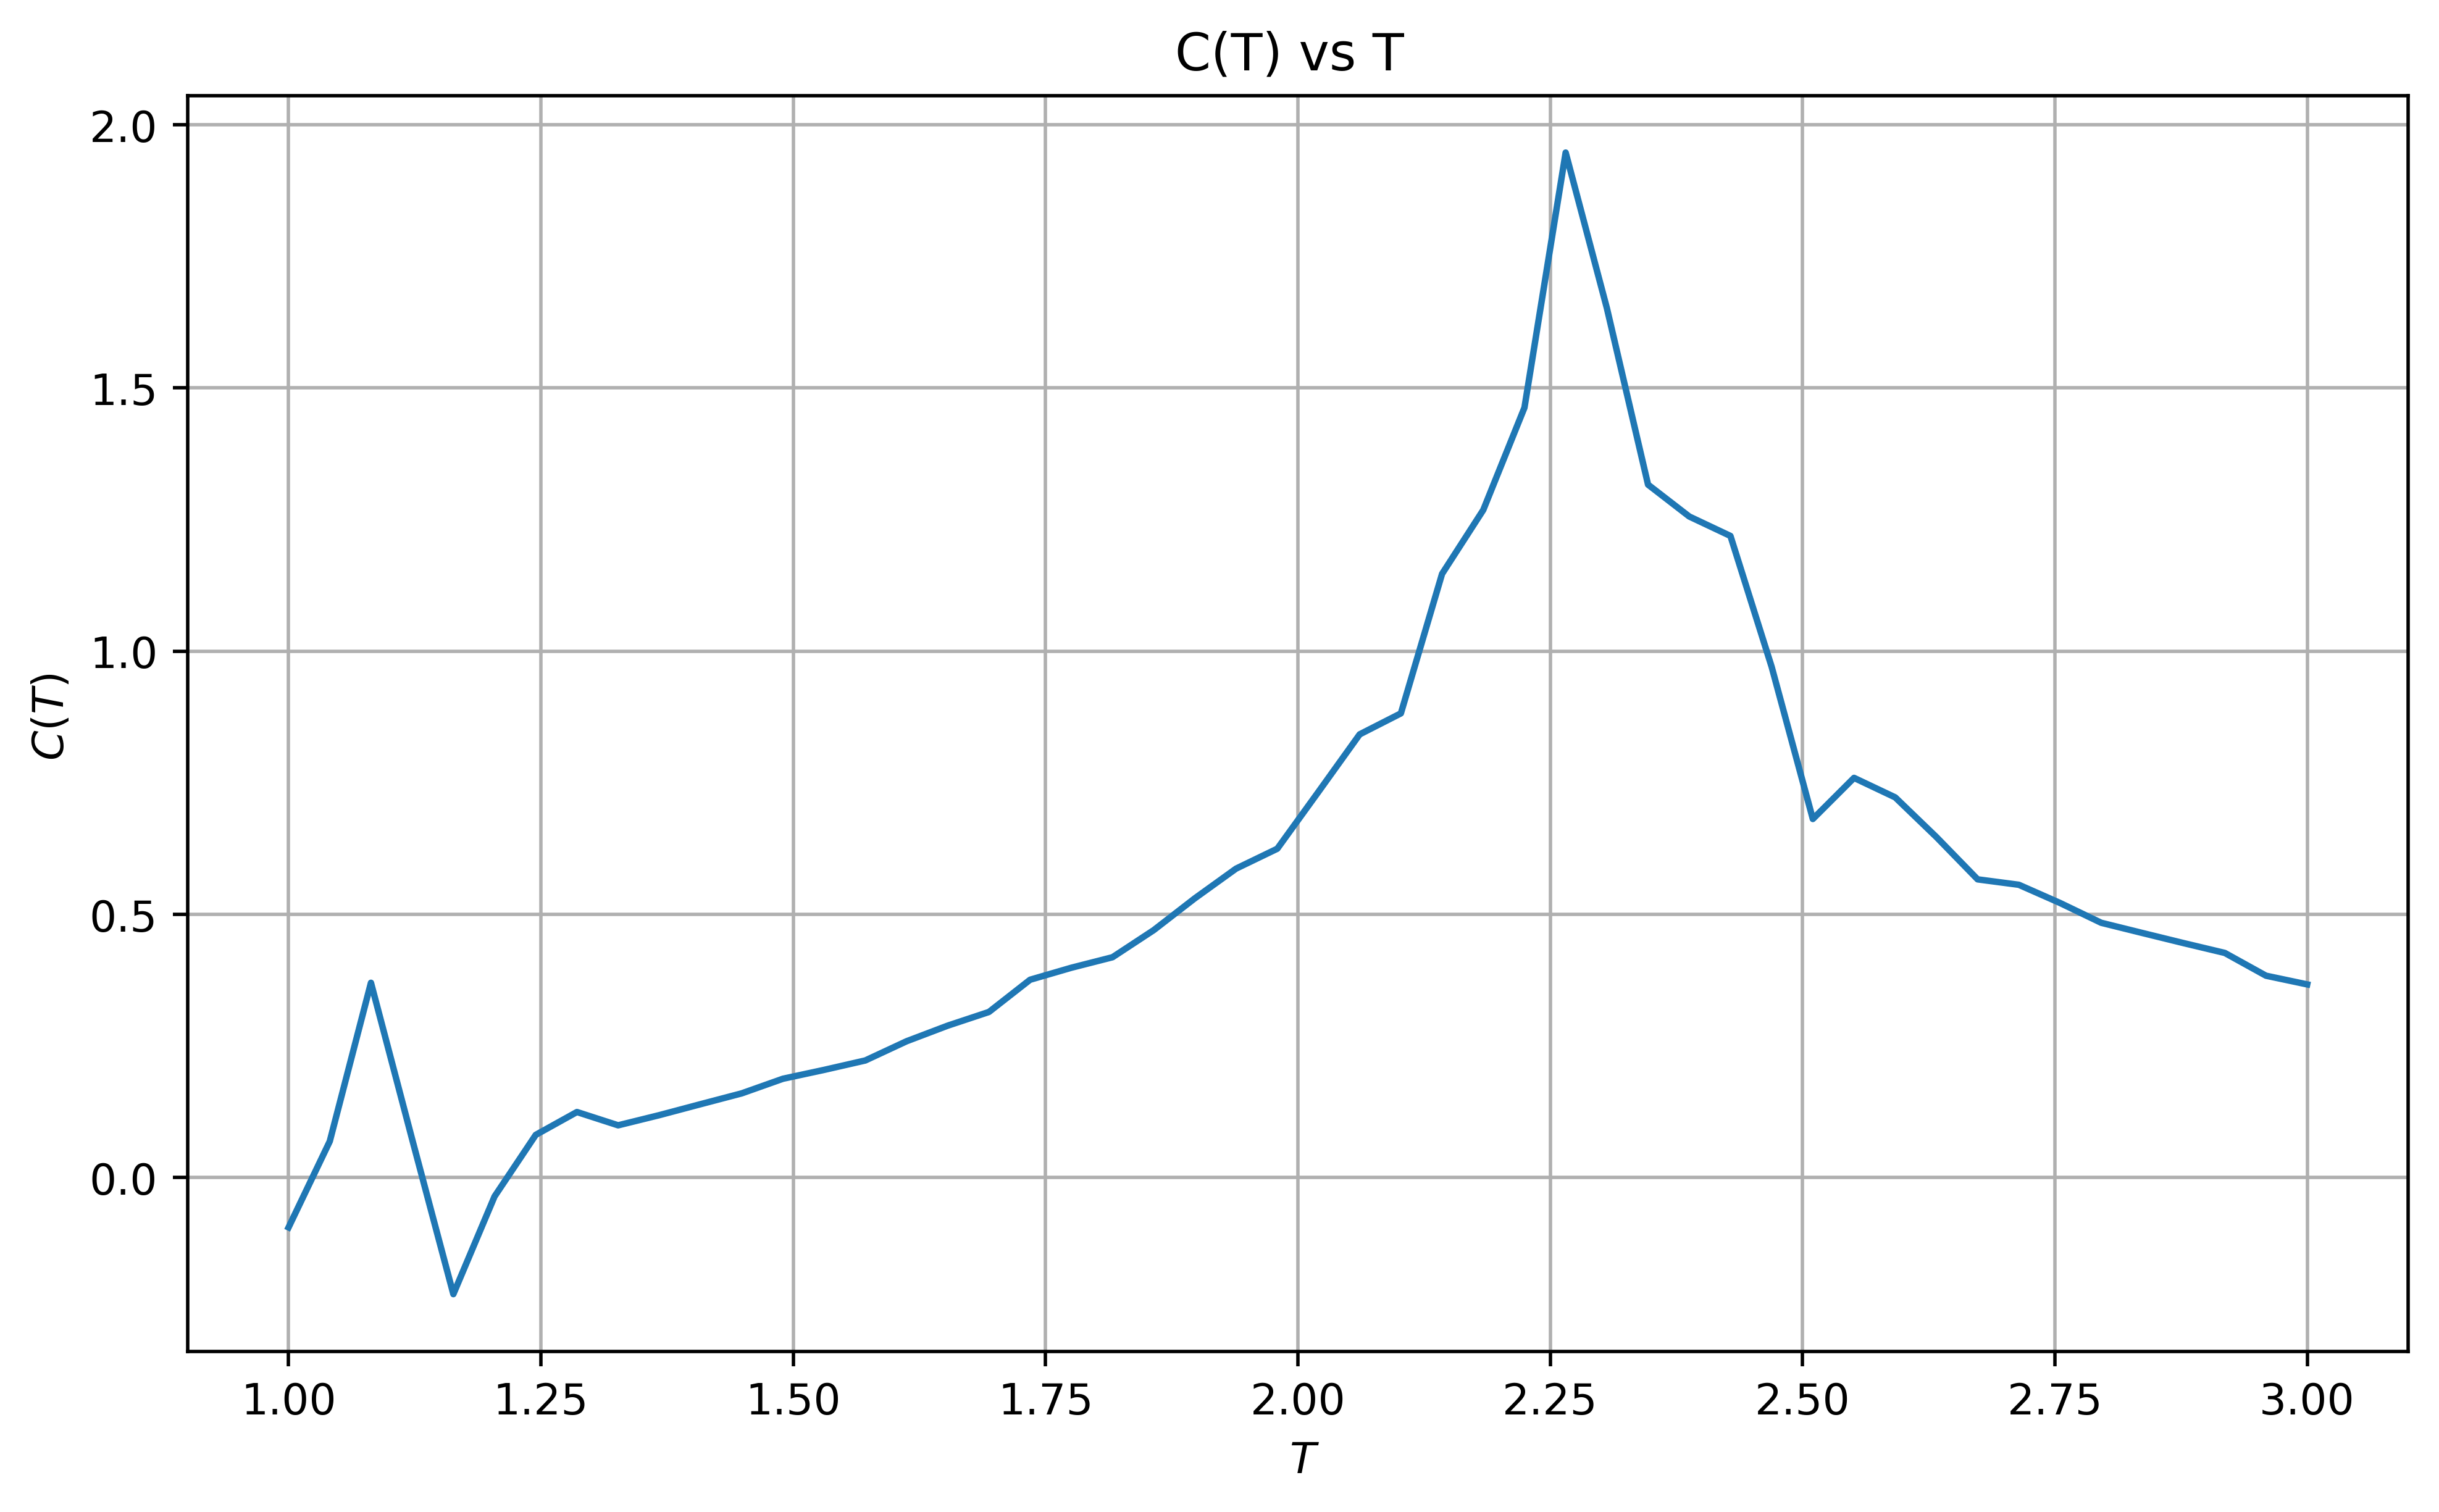

In [116]:
T_uniform = np.linspace(Tvals.min(), Tvals.max(), 50)
e_interp_func = interp1d(Tvals, eAvgVals, kind='cubic')
e_uniform = e_interp_func(T_uniform)

C_uniform = np.gradient(e_uniform, T_uniform)


plt.figure(figsize=(8, 5),dpi=500)
plt.plot(T_uniform, C_uniform )
plt.xlabel(" $T$")
plt.ylabel(" $C(T)$")
plt.title(r"C(T) vs T ")
plt.grid(True)
plt.tight_layout()
plt.show()

# Extra Analysis for Fitting

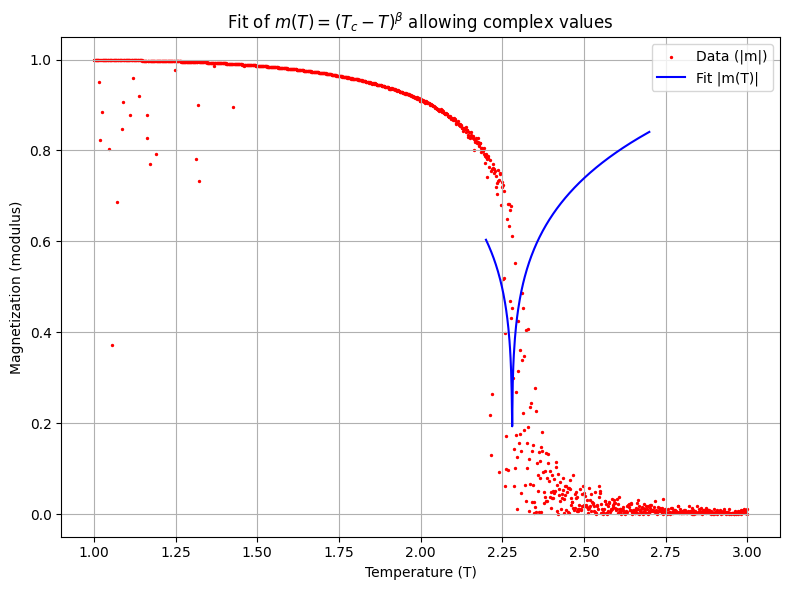

T_c = 2.280000
beta = 0.200000
min |m| = 0.192967, max |m| = 0.840717


In [ ]:
from scipy.optimize import least_squares


def magnetization_complex(T, Tc, beta):
    T = np.asarray(T, dtype=np.complex128)  # Ensure complex-valued computation
    return (Tc - T) ** beta



def residuals_complex(params, T, M):
    Tc, beta = params
    model_vals = magnetization_complex(T, Tc, beta)
    return np.concatenate([
        np.real(model_vals - M),
        np.imag(model_vals - M)
    ])

# --- Prepare data (as complex just in case) ---
Tvals_fit = np.asarray(Tvals)
mvals_fit = np.abs(np.asarray(mAvgVals)) + 0j  # cast to complex

# --- Mask for fitting window ---
mask = (Tvals_fit > 0) & (Tvals_fit < 3)
T_fit_data = Tvals_fit[mask]
M_fit_data = mvals_fit[mask]

# --- Initial guess ---
initial_guess = [2.22, 0.1]

# --- Fit using least_squares ---
res = least_squares(
    residuals_complex,
    initial_guess,
    args=(T_fit_data, M_fit_data),
    bounds=([2.20, 0.05], [2.28, 0.2])
)

Tc_fit, beta_fit = res.x

# --- Evaluate fit on a broader range ---
T_plot = np.linspace(2.2, 2.7, 300)
M_plot = magnetization_complex(T_plot, Tc_fit, beta_fit)

# --- Plotting ---
plt.figure(figsize=(8, 6))
plt.scatter(Tvals_fit, np.abs(mvals_fit), s=2, color='red', label='Data (|m|)')
plt.plot(T_plot, np.abs(M_plot), 'b-', label='Fit |m(T)|')
plt.xlabel("Temperature (T)")
plt.ylabel("Magnetization (modulus)")
plt.title(r"Fit of $m(T) = (T_c - T)^\beta$ allowing complex values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Output results ---
print(f"T_c = {Tc_fit:.6f}")
print(f"beta = {beta_fit:.6f}")
print(f"min |m| = {np.abs(M_plot).min():.6f}, max |m| = {np.abs(M_plot).max():.6f}")

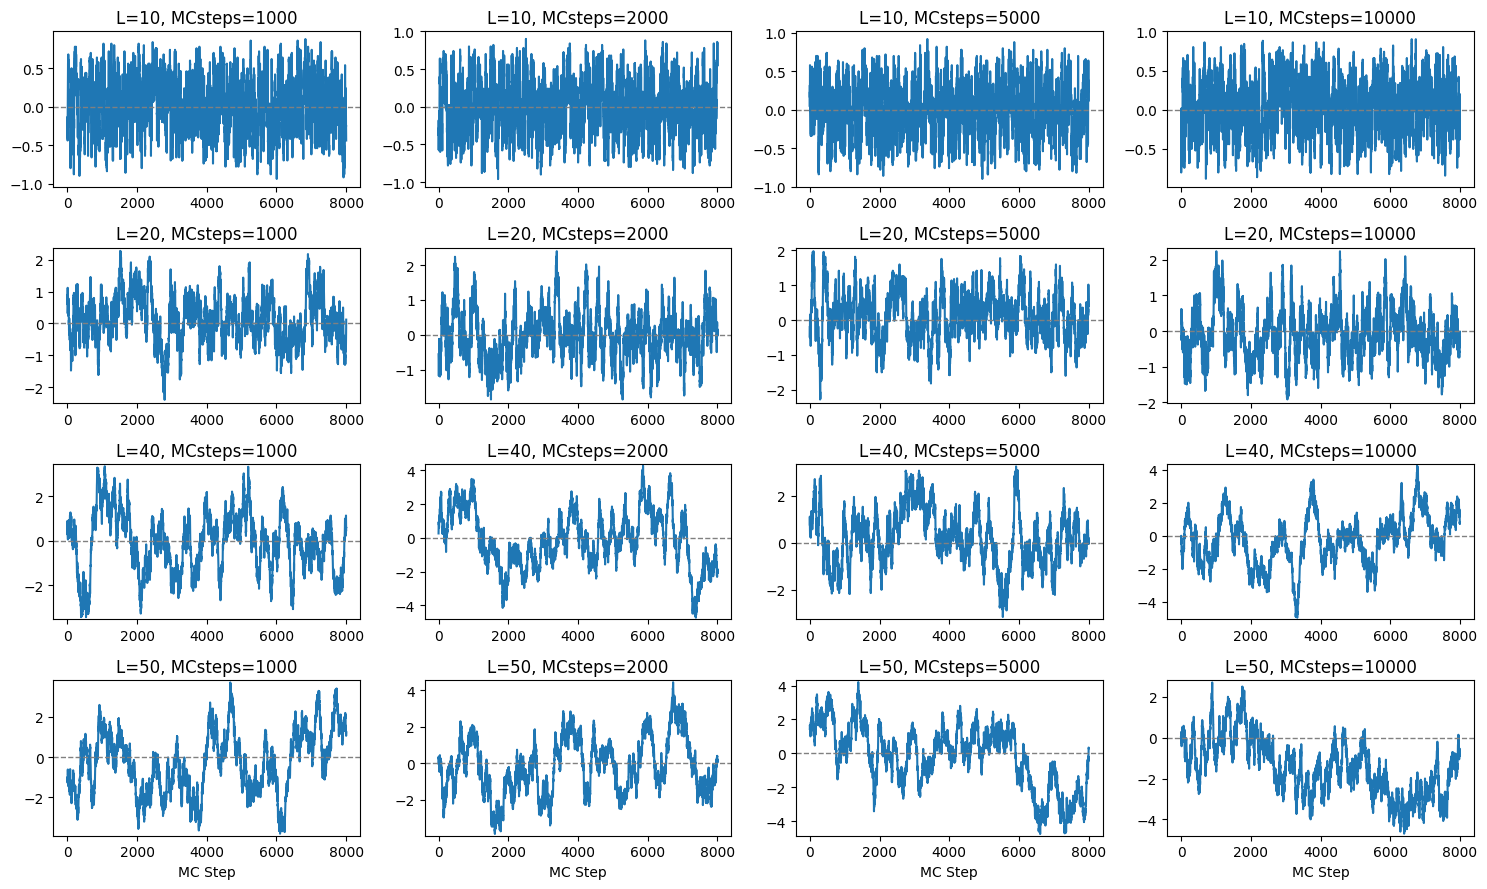

In [22]:
MC_steps_list = [1000, 2000, 5000, 10000]  

fig, axs = plt.subplots(len(L_vals), len(N_vals), figsize=(15, 9), sharey=False)

N=100

for iL, L in enumerate(L_vals):
    magnetization_data[L] = {}
    for iM, M in enumerate(MC_steps_list):
        model = ising.Ising(J, L, N, T, H)
        model.run(MCSteps)
        mvals = model.get_mvals()

        # Store magnetization data
        magnetization_data[L][M] = mvals

        # Plot
        ax = axs[iL, iM]
        ax.plot(mvals)
        ax.set_title(f"L={L}, MCsteps={M}")
        ax.set_ylim(min(mvals) - 0.1, max(mvals) + 0.1)
        ax.axhline(0, color='gray', linestyle='--', linewidth=1)


        if iL == len(L_vals) - 1:
            ax.set_xlabel("MC Step")
        if iN == 0:
            ax.set_ylabel("Magnetization")

plt.tight_layout()
plt.show()

In [ ]:
def magnetization_fit(T, Tc, beta):
    raw = (Tc - T) ** beta
    return np.where(T < Tc, raw, 0.1)  # Use 0.1 instead of 0 for T >= Tc


# --- Prepare your data arrays ---
Tvals_fit = np.asarray(Tvals)
mvals_fit = np.abs(np.asarray(mAvgVals))

# --- Configuration for controlled fitting ---
num_steps = 20

Tc_start = 2.20
Tc_stop = 2.29
Tc_upper = 2.30

beta_start = 0.08
beta_max = 0.2
beta_min = 0.05
epsilon = 1e-6  # small buffer to ensure lower < upper bounds

Tc_initial_guesses = np.linspace(Tc_start, Tc_stop, num_steps)
Tc_results = []
beta_results = []
residuals_list = []

# --- Controlled forward fitting loop ---
beta_lower = beta_min  # Start with minimum beta

for Tc_init in Tc_initial_guesses:
    try:
        bounds = ([Tc_init, beta_lower], [Tc_upper, beta_max - epsilon])  # Enforce strict inequalities

        popt, pcov = curve_fit(
            magnetization_fit,
            Tvals_fit,
            mvals_fit,
            p0=[Tc_init, beta_start],
            bounds=bounds,
            method='trf'
        )

        Tc_fit, beta_fit = popt
        Tc_results.append(Tc_fit)
        beta_results.append(beta_fit)

        # Compute residuals
        m_fit = magnetization_fit(Tvals_fit, Tc_fit, beta_fit)
        residual = np.sum((mvals_fit - m_fit) ** 2)
        residuals_list.append(residual)

        # Update lower bounds for next iteration
        beta_lower = beta_fit
        beta_start = beta_fit

    except RuntimeError:
        Tc_results.append(np.nan)
        beta_results.append(np.nan)
        residuals_list.append(np.nan)

# --- Plotting the progression ---
plt.figure(figsize=(15, 5))

# --- Tc progression ---
plt.subplot(1, 3, 1)
plt.plot(Tc_initial_guesses, Tc_results, 'o-', label='Fitted $T_c$')
plt.axhline(2.269185, color='gray', linestyle='--', label='Exact $T_c$')
plt.xlabel('Initial Guess for $T_c$')
plt.ylabel('Fitted $T_c$')
plt.title('Fitted $T_c$ vs. Initial Guess')
plt.grid(True)
plt.legend()

# --- beta progression ---
plt.subplot(1, 3, 2)
plt.plot(Tc_initial_guesses, beta_results, 'o-', label='Fitted $\\beta$')
plt.axhline(0.125, color='gray', linestyle='--', label='Exact $\\beta$')
plt.xlabel('Initial Guess for $T_c$')
plt.ylabel('Fitted $\\beta$')
plt.title('Fitted $\\beta$ vs. Initial Guess')
plt.grid(True)
plt.legend()

# --- Residuals ---
plt.subplot(1, 3, 3)
plt.plot(Tc_initial_guesses, residuals_list, 'o-', color='purple', label='Residuals')
plt.xlabel('Initial Guess for $T_c$')
plt.ylabel('Sum of Squared Residuals')
plt.title('Fit Residuals vs. Initial Guess')
plt.grid(True)
plt.legend()

plt.suptitle("Controlled Forward Fitting of $m(T) \\sim (T_c - T)^\\beta$")
plt.tight_layout()
plt.show()
